# Jupyter Note - Neural Style Transfer using VGG Network

# Import Packages

In [1]:
import sys
import os
import shutil

from typing import Tuple, Union

from PIL import Image
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

import tqdm

# Print Library Version
print(f"Python version={sys.version}")
print(f"torch version={torch.__version__}")
print(f"torchvision version={torchvision.__version__}")
print(f"matplotlib version={matplotlib.__version__}")
print(f"tdqm version={tqdm.__version__}")

from tqdm import tqdm

Python version=3.12.11 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 08:06:15) [Clang 14.0.6 ]
torch version=2.5.1
torchvision version=0.20.1
matplotlib version=3.10.0
tdqm version=4.67.1


# Define Necessary Modules

## Model Architecture

In [2]:
"""Model Definition"""
class NSTNetwork(nn.Module):
    def __init__(
        self,
        feature_extractor : nn.Module,
        style_layer_names : list[str],
        content_layer_names : list[str],
        use_avgpool : bool = False
    ):
        super().__init__()

        # Get Indices
        self.style_loss_indices = [i for i, _ in enumerate(style_layer_names)]
        self.content_loss_indices = [i for i, name in enumerate(style_layer_names) if name in content_layer_names]

        # Define Normalisation Function
        self.normalise = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )

        slices : list[nn.Sequencial] = []
        slice = nn.Sequential()

        i = 0;
        for layer in feature_extractor.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
                layer = nn.AvgPool2d(layer.kernel_size, layer.stride, layer.padding) if use_avgpool else layer
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            slice.add_module(name, layer)
            
            if name in style_layer_names:
                slices.append(slice)
                slice = nn.Sequential()

        self.extractor = nn.Sequential()
        for i, slice in enumerate(slices,1):
            self.extractor.add_module(f"slice_{i}", slice)

    def forward(self, x) -> list[torch.Tensor]:
        x = self.normalise(x)
        feature_maps : list[torch.Tensor] = []
        for slice in self.extractor.children():
            x = slice(x)
            feature_maps.append(x)
        return feature_maps

## Gram Matrix for Loss function

In [3]:
# Define gram matrix
def gram_matrix(ip : torch.Tensor) -> torch.Tensor:
    num_batch, num_channels, height, width = ip.size()
    feats = ip.view(num_batch * num_channels, width * height)
    gram_mat = torch.mm(feats, feats.t())
    return gram_mat.div(num_batch * num_channels * width * height)

## Auxiliary Functions

### Model Preparaion

In [4]:
def prepare_model(
    device,
    feature_extractor : nn.Module,
    style_layer_names: list[str],
    content_layer_names: list[str],
    use_avgpool : bool = False
) -> nn.Module:
    # Define Our Model
    net = NSTNetwork(
        feature_extractor=feature_extractor,
        style_layer_names=style_layer_names,
        content_layer_names=content_layer_names,
        use_avgpool=use_avgpool
    )

    # Disable Gradient and Turn Model to Evaluation Model
    net.requires_grad_(False)
    net.eval()
    net.to(device)

    return net

### Import image and convert to tensor

In [ ]:

MAX_IMG_SIZE_BIG=(1024, 512)
MAX_IMG_SIZE_SML=(256, 128)
MAX_IMG_SIZE = MAX_IMG_SIZE_BIG if torch.cuda.is_available() else MAX_IMG_SIZE_SML

def images_to_tensor(
    content_image_filepath : str, 
    style_image_filepath : str,
) -> Tuple[torch.Tensor, torch.Tensor]:
    
    content_img = Image.open(content_image_filepath).convert('RGB')
    style_img = Image.open(style_image_filepath).convert('RGB')

    print(f"Original content image size: {content_img.size}")
    print(f"Original style image size: {style_img.size}")

    # display image to check
    _, axs = plt.subplots(2,2, figsize=(10, 6))
    axs[0,0].set_title(f"{content_image_filepath}")
    axs[0,0].imshow(content_img)
    axs[1,0].set_title(f"{style_image_filepath}")
    axs[1,0].imshow(style_img)

    # Find desire size for images (scale-down)
    (max_width, max_height) = MAX_IMG_SIZE
    (new_width, new_height) = content_img.size

    scaling_factor : Union[None | int] = None

    if content_img.width > max_width and content_img.height <= max_height:
        scaling_factor = max_width / content_img.width
    elif content_img.height > max_height and content_img.width <= max_width:
        scaling_factor = max_height / content_img.height
    elif content_img.height > max_height and content_img.width > max_width:
        scaling_factor = min(
          max_width / content_img.width,
          max_height / content_img.height
        )
    
    # Scale-down the images
    if scaling_factor is not None:
        (new_width, new_height) = (
            int(content_img.width * scaling_factor), 
            int(content_img.height * scaling_factor)
        )
        content_img = content_img.resize((new_width, new_height), Image.LANCZOS)
        style_img = style_img.resize((new_width, new_height), Image.LANCZOS)

    print(f"New content image size: {content_img.size}")
    print(f"New style image size: {style_img.size}")

    torch_transformation = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])

    content_img = torch_transformation(content_img).unsqueeze(0)
    style_img = torch_transformation(style_img).unsqueeze(0)

    # Display Processed Image, Sub plt
    axs[0, 1].set_title(f"{content_image_filepath} Processed")
    axs[0, 1].imshow(content_img.squeeze(0).cpu().detach().numpy().transpose(1,2,0))
    axs[1, 1].set_title(f"{style_image_filepath} Processed")
    axs[1, 1].imshow(style_img.squeeze(0).cpu().detach().numpy().transpose(1,2,0))

    return (content_img.to(torch.float), style_img.to(torch.float))

## Style Transfering Process

In [6]:
def style_transfer(
    # neural network
    net : nn.Module,
    # Inputs
    input_image : torch.Tensor,
    content_image : torch.Tensor,
    style_image : torch.Tensor,

    # Optimiser
    lr : float,

    # loss function
    wt_style : float,
    wt_content : float,

    # Transfering Process
    num_epochs : int,
    loss_saving_freq : int,
    img_saving_freq : int,

    output_path : str
) -> Tuple[list[float], list[float]]:

    # Clean Output Directory
    if os.path.exists(output_path):
        shutil.rmtree(output_path) # Deletes the directory and all its contents
    os.makedirs(output_path) # Re-creates the empty directory

    input_image.requires_grad_(True)

    opt = optim.LBFGS([input_image], lr=lr)

    epoch_style_losses = []
    epoch_content_losses = []

    for curr_epoch in range(1, num_epochs+1):

        input_image.data.clamp_(0, 1)

        opt.zero_grad()

        epoch_style_loss = 0
        epoch_content_loss = 0

        x = input_image
        yc = content_image.detach()
        ys = style_image.detach()

        feature_maps_x = net(x)
        with torch.no_grad():
            feature_maps_yc = net(yc)
            feature_maps_ys = net(ys)

        for i,(f_x,f_yc,f_ys) in enumerate(zip(feature_maps_x,feature_maps_yc,feature_maps_ys)):
            if i in net.style_loss_indices:
                epoch_style_loss += F.mse_loss(gram_matrix(f_x), gram_matrix(f_ys.detach()).detach())
            if i in net.content_loss_indices:
                epoch_content_loss += F.mse_loss(f_x, f_yc.detach())

        epoch_style_loss *= wt_style
        epoch_content_loss *= wt_content

        total_loss = epoch_style_loss + epoch_content_loss
        total_loss.backward()

        def closure() -> torch.Tensor:
            return total_loss

        if curr_epoch % loss_saving_freq == 0:
            epoch_style_losses += [epoch_style_loss.cpu().detach().numpy()]
            epoch_content_losses += [epoch_content_loss.cpu().detach().numpy()]
            print(f"epoch number {curr_epoch}")
            print(f"style loss = {epoch_style_loss:.4f}, content loss = {epoch_content_loss:.4f}")

        if curr_epoch % img_saving_freq == 0:
            display_image = input_image.data.clamp_(0, 1).squeeze(0).cpu().detach()
            plt.figure()
            plt.title(f"epoch number {curr_epoch}")
            plt.imshow(display_image.numpy().transpose(1,2,0))
            plt.show()
            torchvision.utils.save_image(
                display_image,
                f"{output_path}/image_{curr_epoch}.jpg"
            )

        opt.step(closure=closure)

    return (epoch_style_losses, epoch_content_losses)

# Google Drive Setup

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# Change the current working directory
YOUR_WORKING_DIR_GDRIVE="MyDrive/Colab/neural-style-transfer/notebook"

import os;
os.chdir(f"/content/gdrive/{YOUR_WORKING_DIR_GDRIVE}")
print(os.getcwd())

# Main Functions

## Select Device

In [7]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
print(f"Using device: {device}")

Using device: cpu


## Create Directories if not exist

In [8]:
# Create Directory
INPUT_PATH="./inputs"
OUTPUT_PATH="./outputs"
os.makedirs(INPUT_PATH, exist_ok=True) # Input Directory
os.makedirs(OUTPUT_PATH, exist_ok=True) # Output Directory

## Prepare model

### Import pretrained model(s)

In [9]:
vgg19_model = torchvision.models.vgg19(weights=torchvision.models.vgg.VGG19_Weights.DEFAULT)
# print(vgg19_model)

vgg16_model = torchvision.models.vgg16(weights=torchvision.models.vgg.VGG16_Weights.DEFAULT)
print(vgg16_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Build Our Model

In [10]:
feature_extractor=vgg19_model.features
style_layer_names=["relu_1", "relu_2", "relu_3", "relu_4", "relu_5"]
content_layer_names=["relu_4"]
use_avgpool=False

net = prepare_model(
    device,
    feature_extractor=feature_extractor,
    style_layer_names=style_layer_names,
    content_layer_names=content_layer_names,
    use_avgpool=use_avgpool
)

In [11]:
# Print Network Aritechture
print(net)

NSTNetwork(
  (normalise): Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  (extractor): Sequential(
    (slice_1): Sequential(
      (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu_1): ReLU()
    )
    (slice_2): Sequential(
      (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu_2): ReLU()
    )
    (slice_3): Sequential(
      (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu_3): ReLU()
    )
    (slice_4): Sequential(
      (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu_4): ReLU()
    )
    (slice_5): Sequential(
      (pool_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu_5): ReLU()
    )
  )
)

## Prepare Image Tensors

Original content image size: (1280, 1158)
Original style image size: (485, 485)
New content image size: (141, 128)
New style image size: (141, 128)
style_image.shape: torch.Size([1, 3, 128, 141])
content_image.shape: torch.Size([1, 3, 128, 141])


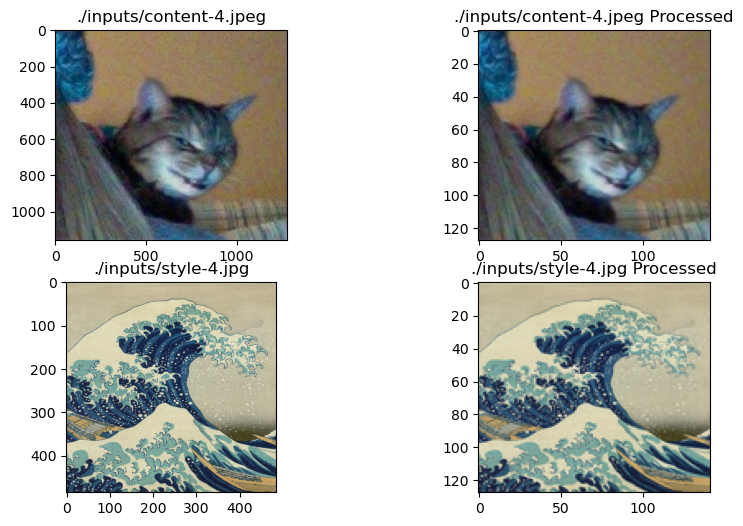

In [24]:
# Get Style and Content Tensors
(content_image, style_image) = images_to_tensor(
    f"{INPUT_PATH}/content-4.jpeg",
    f"{INPUT_PATH}/style-4.jpg"
)

(content_image, style_image)  = (content_image.to(device).detach(), style_image.to(device).detach())

print(f"style_image.shape: {style_image.shape}")
print(f"content_image.shape: {content_image.shape}")

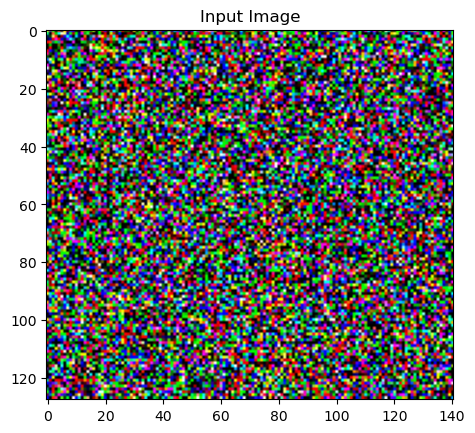

In [25]:
# Get Input Tensor
init_mode = "random"

if init_mode == "content":
    # initialize as the content image
    input_image = content_image.clone().to(device)
else:
    input_image = torch.randn(content_image.data.size(), device=device)

# Display input image
plt.figure()
plt.title("Input Image")
plt.imshow(input_image.squeeze(0).cpu().detach().numpy().transpose(1,2,0).clip(0,1));

## Transfer the image

epoch number 10
style loss = 126.6428, content loss = 21.2270
epoch number 20
style loss = 7.7422, content loss = 15.8888
epoch number 30
style loss = 3.9280, content loss = 13.3229
epoch number 40
style loss = 2.9593, content loss = 11.5021
epoch number 50
style loss = 2.5306, content loss = 10.1768
epoch number 60
style loss = 2.1784, content loss = 9.2423
epoch number 70
style loss = 2.0531, content loss = 8.5336
epoch number 80
style loss = 1.9087, content loss = 8.0362
epoch number 90
style loss = 1.8334, content loss = 7.6113
epoch number 100
style loss = 1.7633, content loss = 7.3200


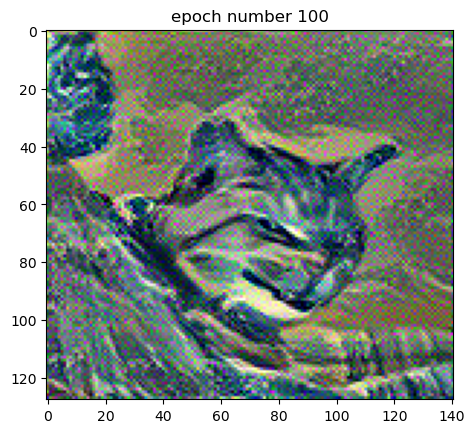

epoch number 110
style loss = 1.7014, content loss = 7.0925
epoch number 120
style loss = 1.6485, content loss = 6.9154
epoch number 130
style loss = 1.6283, content loss = 6.7596
epoch number 140
style loss = 1.6076, content loss = 6.6361
epoch number 150
style loss = 1.5867, content loss = 6.5370
epoch number 160
style loss = 1.5636, content loss = 6.4576
epoch number 170
style loss = 1.5477, content loss = 6.3880
epoch number 180
style loss = 1.5320, content loss = 6.3377
epoch number 190
style loss = 1.5180, content loss = 6.2976
epoch number 200
style loss = 1.5152, content loss = 6.2529


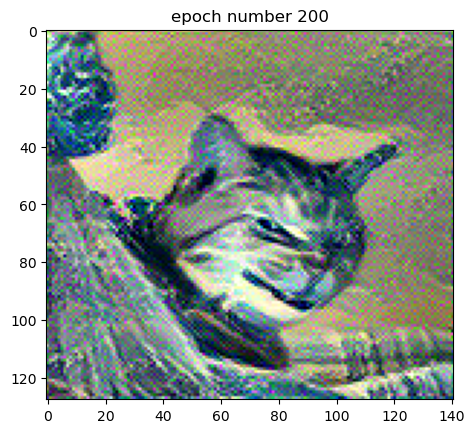

epoch number 210
style loss = 1.4959, content loss = 6.2275
epoch number 220
style loss = 1.4925, content loss = 6.1873
epoch number 230
style loss = 1.4931, content loss = 6.1646
epoch number 240
style loss = 1.4806, content loss = 6.1626
epoch number 250
style loss = 1.4849, content loss = 6.1355
epoch number 260
style loss = 1.4837, content loss = 6.1225
epoch number 270
style loss = 1.5410, content loss = 6.1145
epoch number 280
style loss = 1.5013, content loss = 6.1000
epoch number 290
style loss = 1.4881, content loss = 6.1146
epoch number 300
style loss = 1.5188, content loss = 6.2038


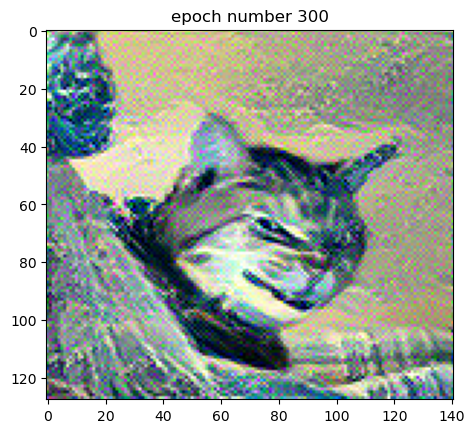

epoch number 310
style loss = 1.5035, content loss = 6.0988
epoch number 320
style loss = 1.6115, content loss = 6.2492
epoch number 330
style loss = 1.5187, content loss = 6.0960
epoch number 340
style loss = 1.5207, content loss = 6.2016
epoch number 350
style loss = 1.5732, content loss = 6.1233
epoch number 360
style loss = 1.7531, content loss = 6.5450
epoch number 370
style loss = 1.6044, content loss = 6.1706
epoch number 380
style loss = 3.0169, content loss = 6.5262
epoch number 390
style loss = 4.4462, content loss = 10.1788
epoch number 400
style loss = 2.1086, content loss = 8.1568


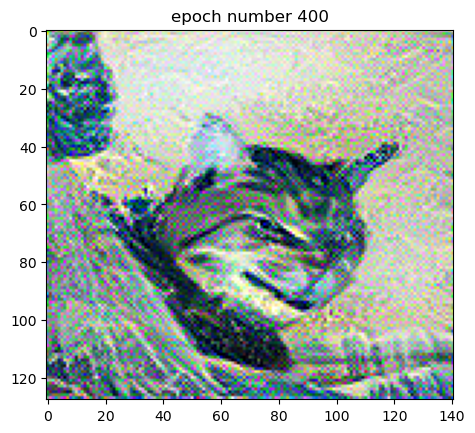

epoch number 410
style loss = 1.8184, content loss = 7.3475
epoch number 420
style loss = 1.6861, content loss = 6.9563
epoch number 430
style loss = 1.6369, content loss = 6.6885
epoch number 440
style loss = 1.6257, content loss = 6.5318
epoch number 450
style loss = 1.5789, content loss = 6.4477
epoch number 460
style loss = 1.5911, content loss = 6.3500
epoch number 470
style loss = 2.0774, content loss = 6.4786
epoch number 480
style loss = 1.5919, content loss = 6.2857
epoch number 490
style loss = 3.2076, content loss = 6.9471
epoch number 500
style loss = 1.6606, content loss = 6.3090


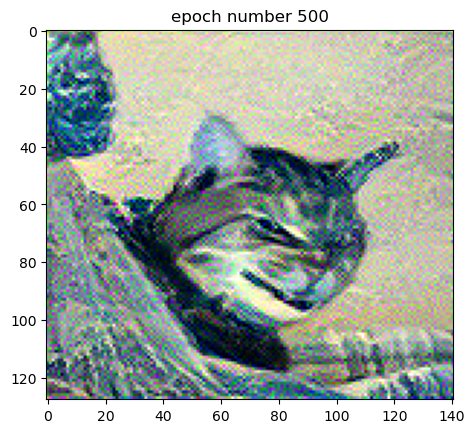

epoch number 510
style loss = 1.7390, content loss = 6.7126
epoch number 520
style loss = 9.9947, content loss = 7.7093
epoch number 530
style loss = 1.7561, content loss = 6.7366
epoch number 540
style loss = 1.6958, content loss = 6.4128
epoch number 550
style loss = 1.7407, content loss = 6.4705
epoch number 560
style loss = 2.0058, content loss = 6.9153
epoch number 570
style loss = 2.0415, content loss = 7.0738
epoch number 580
style loss = 2.1369, content loss = 7.0391
epoch number 590
style loss = 2.4956, content loss = 7.3870
epoch number 600
style loss = 1.9920, content loss = 6.8771


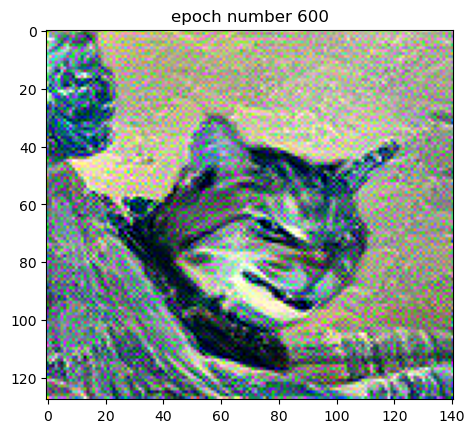

epoch number 610
style loss = 7.8585, content loss = 9.6596
epoch number 620
style loss = 2.1663, content loss = 7.0032
epoch number 630
style loss = 5.3043, content loss = 10.0191
epoch number 640
style loss = 2.0493, content loss = 7.2228
epoch number 650
style loss = 2.2749, content loss = 7.5702
epoch number 660
style loss = 7.8664, content loss = 8.2031
epoch number 670
style loss = 1.9326, content loss = 7.2920
epoch number 680
style loss = 1.8757, content loss = 6.9627
epoch number 690
style loss = 1.9116, content loss = 6.8501
epoch number 700
style loss = 2.0865, content loss = 7.2522


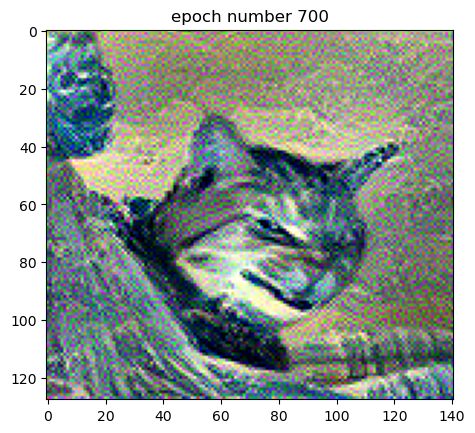

epoch number 710
style loss = 2.4249, content loss = 8.0345
epoch number 720
style loss = 1.8679, content loss = 7.0120
epoch number 730
style loss = 2.3168, content loss = 6.9954
epoch number 740
style loss = 3.7534, content loss = 7.4471
epoch number 750
style loss = 2.2864, content loss = 8.0595
epoch number 760
style loss = 1.9284, content loss = 6.9228
epoch number 770
style loss = 2.3014, content loss = 7.7798
epoch number 780
style loss = 3.3650, content loss = 8.4478
epoch number 790
style loss = 2.8829, content loss = 9.1069
epoch number 800
style loss = 2.6430, content loss = 8.2479


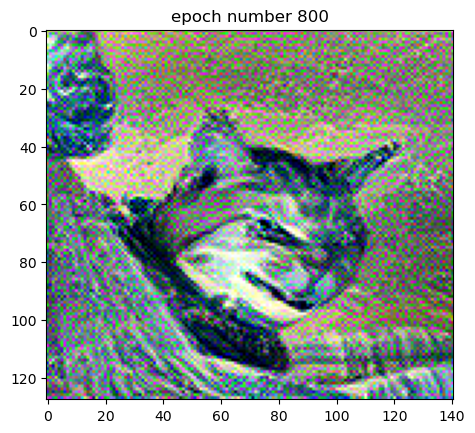

epoch number 810
style loss = 3.1720, content loss = 8.1767
epoch number 820
style loss = 2.2329, content loss = 7.6425
epoch number 830
style loss = 2.3072, content loss = 7.6397
epoch number 840
style loss = 2.0468, content loss = 7.3878
epoch number 850
style loss = 3.7952, content loss = 8.9694
epoch number 860
style loss = 1.8278, content loss = 7.1041
epoch number 870
style loss = 1.9770, content loss = 6.9550
epoch number 880
style loss = 3.9906, content loss = 8.8358
epoch number 890
style loss = 1.8617, content loss = 7.1987
epoch number 900
style loss = 2.5290, content loss = 6.8151


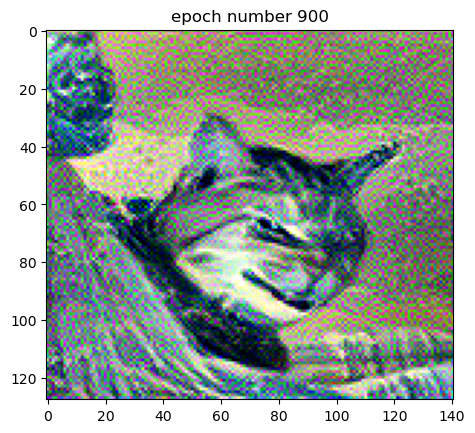

epoch number 910
style loss = 2.8850, content loss = 8.4582
epoch number 920
style loss = 4.1394, content loss = 10.2704
epoch number 930
style loss = 2.4738, content loss = 8.0898
epoch number 940
style loss = 3.3842, content loss = 9.5421
epoch number 950
style loss = 2.0225, content loss = 8.0031
epoch number 960
style loss = 1.7800, content loss = 7.3594
epoch number 970
style loss = 2.0006, content loss = 7.1884
epoch number 980
style loss = 2.1582, content loss = 6.8489
epoch number 990
style loss = 56.8032, content loss = 15.6648
epoch number 1000
style loss = 2.4235, content loss = 8.4706


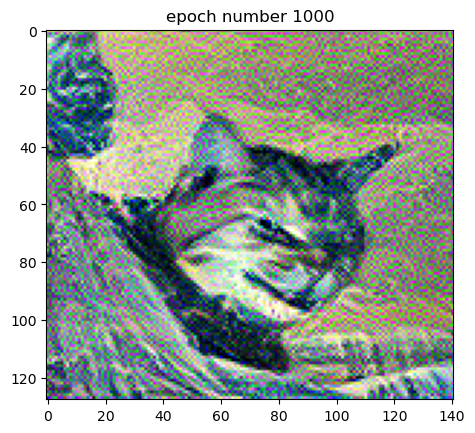

CPU times: user 19min 15s, sys: 1min 7s, total: 20min 23s
Wall time: 3min 33s


In [26]:
%%time

lr=0.5

wt_style=1e5
wt_content=2

num_epochs= 1000
loss_saving_freq = 10
img_saving_freq = 100

epoch_style_losses, epoch_content_losses = style_transfer(
    # Neural Network
    net,

    # Inputs
    input_image,
    content_image,
    style_image,

    # Optimiser
    lr,

    # loss function
    wt_style,
    wt_content,

    # Transfering Process
    num_epochs,
    loss_saving_freq,
    img_saving_freq,

    OUTPUT_PATH
)

### Plot Loss Curve for further analysis

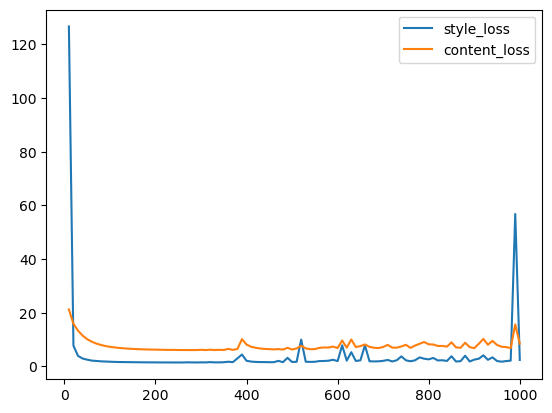

In [27]:
plt.plot(range(loss_saving_freq, num_epochs+1, loss_saving_freq), epoch_style_losses, label='style_loss');
plt.plot(range(loss_saving_freq, num_epochs+1, loss_saving_freq), epoch_content_losses, label='content_loss');
plt.legend();